# TP3 - exercice 3 : jeux de données deséquilibrés & SVMs à coûts asymétriques

Dans cet exercice nous verrons l'impact que peut avoir un déséquilibre entre classes sur l'apprentissage d'un modèle SVM, et les moyens dont on dispose pour le contrôler.

Nous travaillerons toujours à partir de la classe [**SVC**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), et du jeu de données simulées **moon**, que l'on peut générer à partir de la fonction [make_moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) du module **datasets** de scikit-learn. 


Cet exercice sera également l'occasion de revoir les différents critères permettant de quantifier les peformances d'un modèle de classification (binaire), et en particulier de revoir comment construire des courbes ROC.

## Question 1.  Générer un jeu de données *moons* en introduisant un déséquilibre dans le jeu d'apprentissage avec le code ci-dessous, et le représenter. De combien d'instances d'apprentissage et de test dispose t'on pour chacune des deux catégories ?
* les objets sur lesquels nous travaillerons par la suite sont **Xtrain**, **Xtest**, **ytrain**, **ytest**.

In [1]:
# general imports #
#-----------------#
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# generate train / test datasets #
#--------------------------------#
from sklearn.datasets import make_moons
# generate dataset
X, y = make_moons(1000, noise = 0.4, random_state=27)
# split (evenly) in train test 
from sklearn.model_selection import train_test_split
Xtrain_temp, Xtest, ytrain_temp, ytest = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 27) 
# subsample class 0 in training data
ind_0 = np.argwhere(ytrain_temp == 0).ravel()
ind_1 = np.argwhere(ytrain_temp == 1).ravel()
n_sple = int(np.round(len(ind_0))/5)
ind_0_sple = ind_0[:n_sple]
ind_sple = np.concatenate( [ind_1, ind_0_sple] )
Xtrain = Xtrain_temp[ind_sple,:]
ytrain = ytrain_temp[ind_sple]

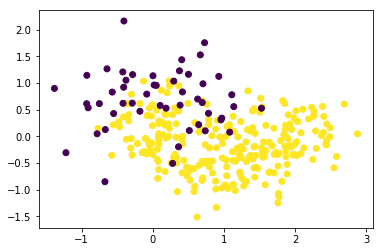

--> training dataset made of 50 instances of class 0 and 250 instances of class 1
--> test dataset made of 250 instances of class 0 and 250 instances of class 1


In [2]:
# plot
fig = plt.figure()
plt.scatter(Xtrain[:,0], Xtrain[:,1], c = ytrain)
plt.show()
n0 = len(np.argwhere(ytrain == 0))
n1 = len(np.argwhere(ytrain == 1))
print('--> training dataset made of %d instances of class 0 and %d instances of class 1' % (n0,n1))
n0 = len(np.argwhere(ytest == 0))
n1 = len(np.argwhere(ytest == 1))
print('--> test dataset made of %d instances of class 0 and %d instances of class 1' % (n0,n1))

## Question 2.  Optimiser les paramètres $C$ et $\gamma$ d'un classifieur SVM à noyau radial (RBF) en utilisant les données d'apprentissage et la classe *GridSearchCV*. 
* On pourra par exemple considérer les grilles de paramètres utilisées dans l'exercice prédédent.

In [3]:
# optimise SVM model #
#--------------------#
# instantiate model
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
# define grid of parameter
C_grid = np.logspace(-3,3, 10)
gamma_grid = [0.1, 0.25, 0.5, 0.75, 1, 2]
param_grid = {'C' : C_grid,
             'gamma' : gamma_grid}
# optimise parameter
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv= 10)
grid_search.fit(Xtrain, ytrain)
# show results
print("The best parameters are %s with a score of %0.2f"
     % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.89


## Question 3.  Calculer (par validation croisée) la matrice de confusion correspondante et le niveau de rappel (*recall*) par classe. Qu'observez-vous ? Comment l'explique t'on ?
* pour calculer la matrice de confusion correspondante, on pourra se baser sur la fonction **cross_val_predict** qui permet de réaliser une expérience de validation croisée, et d'obtenir les prédictions individuelles (et non directement le taux de bonne classification).
* on rappelle qu'à l'issue de l'étape d'optimisation, l'objet **GridSearchCV** contient le meilleur modèle (appris sur l'ensemble du jeu d'apprentissage) dans son champ **best\_estimator\_**. Il suffit donc de le passer à la fonction **cross_val_predict**.
* on rappelle enfin qu'on peut obtenir la matrice de confusion via la fonction **confusion_matrix** du module *metrics*. La fonction **classification_report** (du même module) permet d'obtenir un petit "rapport" donnant les précisions et rappels par classe.

In [4]:
# show confusion matrix #
#-----------------------#
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(grid_search.best_estimator_, Xtrain, ytrain, cv = 10)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print("*** confusion matrix ***")
print(confusion_matrix(ytrain, pred))
print("*** classification report ***")
print(classification_report(ytrain, pred))

*** confusion matrix ***
[[ 24  26]
 [  6 244]]
*** classification report ***
             precision    recall  f1-score   support

          0       0.80      0.48      0.60        50
          1       0.90      0.98      0.94       250

avg / total       0.89      0.89      0.88       300



## Question 4. Réaliser la même analyse en utilisant une SVM à coût asymetriques, en utilisant l'option *class_weight = 'balanced'*. Quelles sont les valeurs des coûts utilisés ? Qu'observe t'on sur le niveau de rappel par classe ?

In [5]:
# do the same with balanced scores #
#----------------------------------#
# instantiate model
svm_w = SVC(kernel = 'rbf', class_weight = 'balanced')
# optimise parameter
grid_search_w = GridSearchCV(svm_w, param_grid, cv= 10)
grid_search_w.fit(Xtrain, ytrain)
# show results
print("The best parameters are %s with a score of %0.2f"
     % (grid_search_w.best_params_, grid_search_w.best_score_))
# show confusiokn matrix & report
pred_w = cross_val_predict(grid_search_w.best_estimator_, Xtrain, ytrain, cv = 10)
print("*** confusion matrix ***")
print(confusion_matrix(ytrain, pred_w))
print("*** classification report ***")
print(classification_report(ytrain, pred_w))

The best parameters are {'C': 215.44346900318823, 'gamma': 0.5} with a score of 0.86
*** confusion matrix ***
[[ 44   6]
 [ 36 214]]
*** classification report ***
             precision    recall  f1-score   support

          0       0.55      0.88      0.68        50
          1       0.97      0.86      0.91       250

avg / total       0.90      0.86      0.87       300



## Question 5. Calculer (par validation croisée) les prédictions correspondantes et comparer les courbes ROC et les AUC correspondantes.
* la courbe ROC d'une SVM peut être construite en considérant le score du modèle plutôt que la prédiction 0/1. On peut l'obtenir avec la fonction **cross_val_predict** en utilisant l'option **method = 'decision_function'**.
* se référer à la documentation des fonctions [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) et [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) du package *metrics* pour la construction de ces indicateurs.

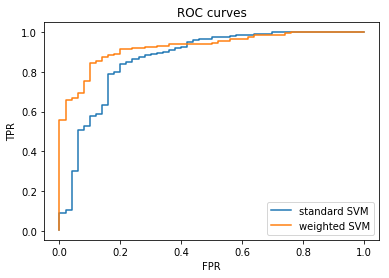

auc of standard model = 0.867360 ; auc of weighted model = 0.926240


In [6]:
# compare roc curves #
#--------------------#
# compute scores
scores = cross_val_predict(grid_search.best_estimator_, Xtrain, ytrain, cv = 10, method = 'decision_function')
scores_w = cross_val_predict(grid_search_w.best_estimator_, Xtrain, ytrain, cv = 10, method = 'decision_function')
# build roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytrain, scores)
fpr_w, tpr_w, thresholds = roc_curve(ytrain, scores_w)
# plot
plt.plot(fpr, tpr, label = 'standard SVM')
plt.plot(fpr_w, tpr_w, label = 'weighted SVM')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.show()
# compute corresponding AUCs
from sklearn.metrics import roc_auc_score
auc_std = roc_auc_score(ytrain, scores)
auc_weight = roc_auc_score(ytrain, scores_w)
print('auc of standard model = %f ; auc of weighted model = %f' % (auc_std, auc_weight))

## Question 6. Une autre stratégie pour contrôler le déséquilibre consiste à utiliser une SVM standard (i.e., sans coûts asymétriques) mais à considérer un critère prenant en compte le déséquilibre des classes lors de l'optimisation du modèle. Evaluer cette stratégie en prenant comme critère l'AUC. Comparer la courbe ROC obtenue (par validation croisée) aux deux courbes ROC précédentes ainsi que les taux de rappel par classe. Que constate t'on ? Les deux stratégies sont-elles équivalentes ?
* on peut spéficier le critère de performance à considérer lors de l'optimisation des paramètres via l'argument **scoring** lors de la construction de l'objet **GridSearchCV**. Pour utiliser l'AUC, il faut spécifier **scoring = 'roc_auc'**.

In [7]:
## evalaute strategy of optimising svm using standard cost but using AUC #
#------------------------------------------------------------------------#
# instantiate model
svm_a = SVC(kernel = 'rbf')
# optimise parameter
grid_search_a = GridSearchCV(svm_a, param_grid, cv= 10, scoring = 'roc_auc')
grid_search_a.fit(Xtrain, ytrain)
# show results
print("The best parameters are %s with a score of %0.2f"
     % (grid_search_a.best_params_, grid_search_a.best_score_))
# show confusionn matrix & report
pred_a = cross_val_predict(grid_search_a.best_estimator_, Xtrain, ytrain, cv = 10)
print("*** confusion matrix ***")
print(confusion_matrix(ytrain, pred_a))
print("*** classification report ***")
print(classification_report(ytrain, pred_a))

The best parameters are {'C': 215.44346900318823, 'gamma': 0.25} with a score of 0.93
*** confusion matrix ***
[[ 24  26]
 [  9 241]]
*** classification report ***
             precision    recall  f1-score   support

          0       0.73      0.48      0.58        50
          1       0.90      0.96      0.93       250

avg / total       0.87      0.88      0.87       300



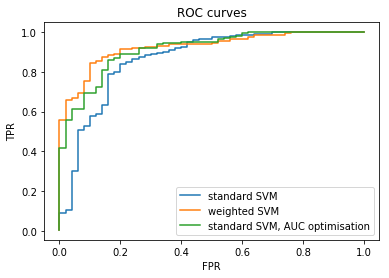

In [8]:
# show corresponding roc curve
scores_a = cross_val_predict(grid_search_a.best_estimator_, Xtrain, ytrain, cv = 10, method = 'decision_function')
fpr_a, tpr_a, thresholds = roc_curve(ytrain, scores_a)
# plot
plt.plot(fpr, tpr, label = 'standard SVM')
plt.plot(fpr_w, tpr_w, label = 'weighted SVM')
plt.plot(fpr_a, tpr_a, label = 'standard SVM, AUC optimisation')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.show()

## Question 7. Enfin, confirmer ces observations en évaluant les 3 modèles sur le jeu de test (qui ne souffre pas de déséquilibre).
* on considèrera là aussi les courbes ROC et le taux de rappel par classe.

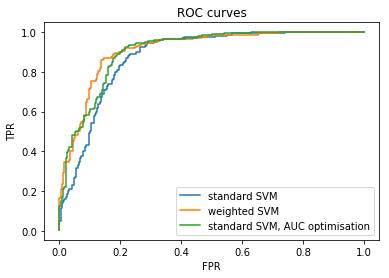

auc of standard model = 0.877872 ; auc of weighted model = 0.912160 ; auc of standard model with AUC optim = 0.905968


In [9]:
# compare roc curves ON TEST SET #
#--------------------------------#
# compute scores
scores = grid_search.best_estimator_.decision_function(Xtest)
scores_w = grid_search_w.best_estimator_.decision_function(Xtest)
scores_a = grid_search_a.best_estimator_.decision_function(Xtest)
# build roc curve
fpr, tpr, thresholds = roc_curve(ytest, scores)
fpr_w, tpr_w, thresholds = roc_curve(ytest, scores_w)
fpr_a, tpr_a, thresholds = roc_curve(ytest, scores_a)
# compute aucs
auc_test = roc_auc_score(ytest, scores)
auc_test_w = roc_auc_score(ytest, scores_w)
auc_test_a = roc_auc_score(ytest, scores_a)
# plot
plt.plot(fpr, tpr, label = 'standard SVM')
plt.plot(fpr_w, tpr_w, label = 'weighted SVM')
plt.plot(fpr_a, tpr_a, label = 'standard SVM, AUC optimisation')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.show()
# print aucs
print('auc of standard model = %f ; auc of weighted model = %f ; auc of standard model with AUC optim = %f' 
      % (auc_test, auc_test_w, auc_test_a))

In [10]:
# evaluate recalls #
#------------------#
preds = grid_search.best_estimator_.predict(Xtest)
preds_w = grid_search_w.best_estimator_.predict(Xtest)
preds_a = grid_search_a.best_estimator_.predict(Xtest)

print("********************************************")
print("**** results on test set - standard SVM ****")
print("********************************************")
print(classification_report(ytest, preds))

print("********************************************")
print("**** results on test set - weighted SVM ****")
print("********************************************")
print(classification_report(ytest, preds_w))

print("******************************************************************")
print("**** results on test set - standard SVM with AUC optimisation ****")
print("******************************************************************")
print(classification_report(ytest, preds_a))

********************************************
**** results on test set - standard SVM ****
********************************************
             precision    recall  f1-score   support

          0       0.96      0.52      0.68       250
          1       0.67      0.98      0.80       250

avg / total       0.81      0.75      0.74       500

********************************************
**** results on test set - weighted SVM ****
********************************************
             precision    recall  f1-score   support

          0       0.87      0.83      0.85       250
          1       0.84      0.88      0.86       250

avg / total       0.85      0.85      0.85       500

******************************************************************
**** results on test set - standard SVM with AUC optimisation ****
******************************************************************
             precision    recall  f1-score   support

          0       0.97      0.52      0.68   